In [1]:
#imports
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import numpy as np
import os
from pprint import pprint
import json

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#constants
#Imports
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import numpy as np
from datasets import Dataset, disable_progress_bars
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
import optuna
import json
import multiprocessing as mp
import shutil
import warnings
from tqdm import tqdm

#Constants
AGES = ['5','6','7','8','9','10','11','12','13','14','15']
KEYLISTS = "Keylists.jsonl"
keylists = []
with open(KEYLISTS, 'r') as f:
    for line in f:
        keylists.append(json.loads(line))

#Dataset name
DATASET = "TCBC_datasets/sniplen5"

#Helper functions
def do_nothing(ex):
    return ex.lower()

def conllu_tokenizer(ex):
    return ex.replace("\n", "\t").replace("|", "\t").split("\t")

def whitespace_tokenizer(ex):
    return ex.split(" ")

In [3]:
train_keys = keylists[1]['train_keys']
eval_keys = keylists[1]['eval_keys']
test_keys = keylists[1]['test_keys']

In [ ]:
def assignLabel(ex):
    age = int(bdf.findAgeFromID(ex))
    if age < 9:
        return '7-8'
    elif age < 13:
        return '9-12'
    else:
        return '13+'

def conllu2RawLemmas(conllu_text):
    conllu_lines = conllu_text.split("\n")
    return " ".join([x.split('\t')[2] for x in conllu_lines if len(x) > 0])


def mapLabels(ex):
    return {'label':[assignLabel(x) for x in ex['book_id']]}

def mapConlluData2RawLemmas(ex):
    return {'data':[conllu2RawLemmas(x) for x in ex['data']]}


In [5]:
ds = Dataset.load_from_disk(DATASET)
#Training dataset
train_ds = ds.filter(lambda x: x['book_id'] in train_keys).shuffle()
train_ds = train_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
train_ds = train_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Filter:   0%|          | 0/228160 [00:00<?, ? examples/s]

Map:   6%|▌         | 9552/166351 [00:00<00:05, 28562.46 examples/s]


IndexError: list index out of range

In [ ]:
#Evaluation dataset
eval_ds = ds.filter(lambda x: x['book_id'] in eval_keys).shuffle()
eval_ds = eval_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
eval_ds = eval_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Map: 100%|██████████| 3503/3503 [00:00<00:00, 5658.77 examples/s]


In [ ]:
#Test dataset
test_ds = ds.filter(lambda x: x['book_id'] in test_keys).shuffle()
test_ds = test_ds.map(mapLabels, batched=True, batch_size=32, load_from_cache_file=False)
test_ds = test_ds.map(mapConlluData2RawLemmas, batched=True, batch_size=16, load_from_cache_file=False)

Map: 100%|██████████| 2641/2641 [00:00<00:00, 5018.00 examples/s]


In [ ]:
#Initialize and fir our vectorizer
vectorizer = TfidfVectorizer(norm='l2', tokenizer=whitespace_tokenizer, preprocessor=do_nothing, max_features=2000).fit([x['data'] for x in train_ds])
#Vectorize datasets
vectorized_train = vectorizer.transform([x['data'] for x in train_ds])
vectorized_eval = vectorizer.transform([x['data'] for x in eval_ds])
vectorized_test = vectorizer.transform([x['data'] for x in test_ds])

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
returnable = {}
c_eval_pairs= []

#Very quick hyperparam optimization as we have computational resources
def objective(trial):
    #Defining hyperparameters to tune
    c = trial.suggest_float('c', 1e-10, 1e+0, log=True)
    pen = trial.suggest_categorical('pen', ['l2'])
    tol = trial.suggest_float('tol', 1e-10, 1e-3, log=True)
    clf = LinearSVC(
        random_state=42,
        C=c,
        tol=tol,
        penalty=pen
    )
    clf.fit(vectorized_train,train_ds['label'])
    predicted = clf.predict(vectorized_eval)
    f1 = f1_score(eval_ds['label'], predicted, average="macro")
    c_eval_pairs.append([c, f1])
    return f1

# Your code for hyperparameter optimization here
study = optuna.create_study(direction='maximize')
optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=50)

#Run with best params
clf = LinearSVC(
    penalty=study.best_trial.params['pen'],
    random_state=42,
    C=study.best_trial.params['c'],
    tol=study.best_trial.params['tol'],
)
clf.fit(vectorized_train, train_ds['label'])
test_predict = clf.predict(vectorized_test)

#Assign returnble values
returnable['f1'] = f1_score(test_ds['label'], test_predict, average="macro")
returnable['labels'] = clf.classes_.tolist()
returnable['conf_matrix'] = metrics.confusion_matrix(test_ds['label'], test_predict).tolist()
returnable['c'] = study.best_trial.params['c']
returnable['tol'] = study.best_trial.params['tol']
returnable['penalty'] = study.best_trial.params['pen']
returnable['c_eval_scores'] = c_eval_pairs

[I 2025-08-27 15:16:32,668] A new study created in memory with name: no-name-c5647077-a189-4c7c-bef8-bb4315343d4c


In [ ]:
pprint(returnable)

{'c': 0.27764262049946187,
 'c_eval_scores': [[0.04271440151317089, 0.5103387543623029],
                   [1.1285994494572602e-06, 0.20559394537676867],
                   [4.650022876016453e-05, 0.20559394537676867],
                   [0.006770421665083378, 0.4465134718919454],
                   [0.008269115051532508, 0.4558790871872864],
                   [1.1012602214925731e-10, 0.20559394537676867],
                   [0.022598399427820836, 0.5025551155082398],
                   [3.322291280717807e-08, 0.20559394537676867],
                   [7.64619930150672e-05, 0.20559394537676867],
                   [4.054465597855323e-06, 0.20559394537676867],
                   [0.9506671704578242, 0.5330699115891079],
                   [0.672741611731461, 0.5326932720623817],
                   [0.5720020908933716, 0.5319224585639826],
                   [0.49171197202240374, 0.5332483175812591],
                   [0.0009706945756005886, 0.25542438859270544],
                   [0.

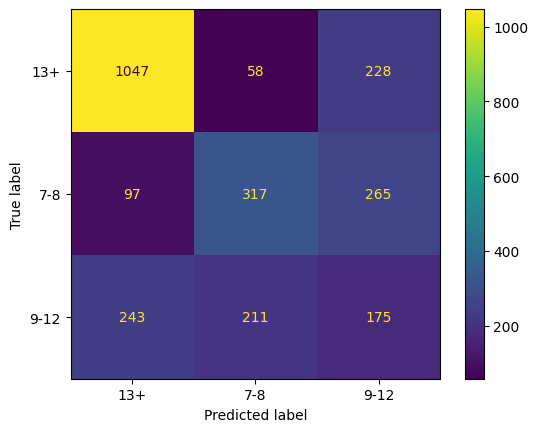

In [ ]:
p = metrics.ConfusionMatrixDisplay(confusion_matrix=np.array(returnable['conf_matrix']), display_labels=returnable['labels'])
p.plot()